In [1]:
from __future__ import division, print_function, unicode_literals
import re
import itertools
import pandas as pd
import numpy as np
from scipy import spatial
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import matplotlib.gridspec as mgridspec
plt.style.use('newsprint.mplstyle')

In [2]:
# local libraries
import sys
sys.path.append('../analysis')
from readers import read_ldjson
import text
from speeches import Speech, SpeechCollection
from spacy import attrs
import plotting

In [3]:
inaugurals = SpeechCollection(['../data/tapp/inaugurals.json'])
speeches = inaugurals.speeches

In [4]:
# def speech_label(speech):
#     return '{}: {}'.format(speech.author, speech.metadata.get('title', 'N/A'))
def custom_titles_func_creator(speeches):
    custom_titles = list(plotting.iter_inaugural_titles(speeches))
    return lambda speech: custom_titles[speeches.index(speech)]
speech_label = custom_titles_func_creator(speeches)

In [5]:
def spacy_similarity(speech1, speech2):
    return speech1.document.similarity(speech2.document)

In [6]:
shared_vocab = list({key for speech in speeches for key in speech.lemma_counts.keys()})
# print('Speeches -- total vocabulary size:', len(shared_vocab))
def cosine_similarity(speech1, speech2):
    # this isn't terribly smart/efficient :(
    xs1 = [speech1.lemma_counts.get(k, 0) for k in shared_vocab]
    xs2 = [speech2.lemma_counts.get(k, 0) for k in shared_vocab]
    dist = spatial.distance.cosine(xs1, xs2)
    return 1 - dist

In [7]:
df_pairwise = plotting.create_pairwise_df(speeches, spacy_similarity, speech_label)

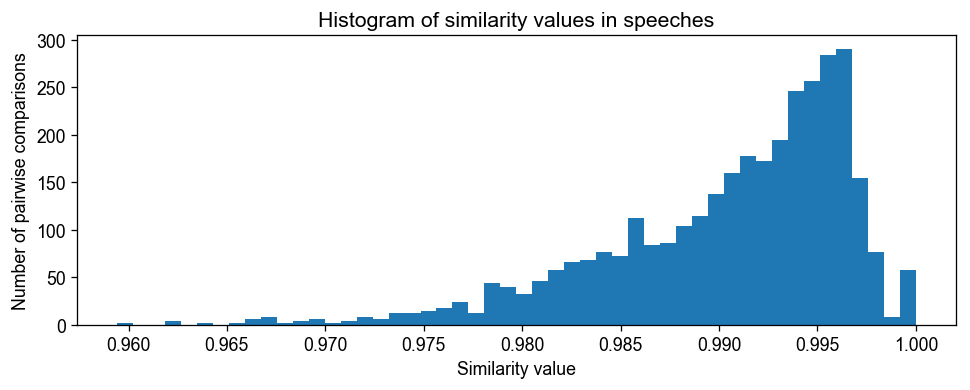

In [8]:
plt.figure(figsize=(8.5, 3.5))
plt.hist(df_pairwise.values.ravel(), bins=50)
plt.title('Histogram of similarity values in speeches')
plt.xlabel('Similarity value')
plt.ylabel('Number of pairwise comparisons')
plt.tight_layout()

In [9]:
# null out the top right triangle
# 1. np.tril zeroes out the top right triangle
# 2. a > 0 converts that into a boolean (2d-)array
# 3. DataFrame.where nulls out all values where the given boolean array is False
df_tril = df_pairwise.where(np.tril(df_pairwise) > 0)

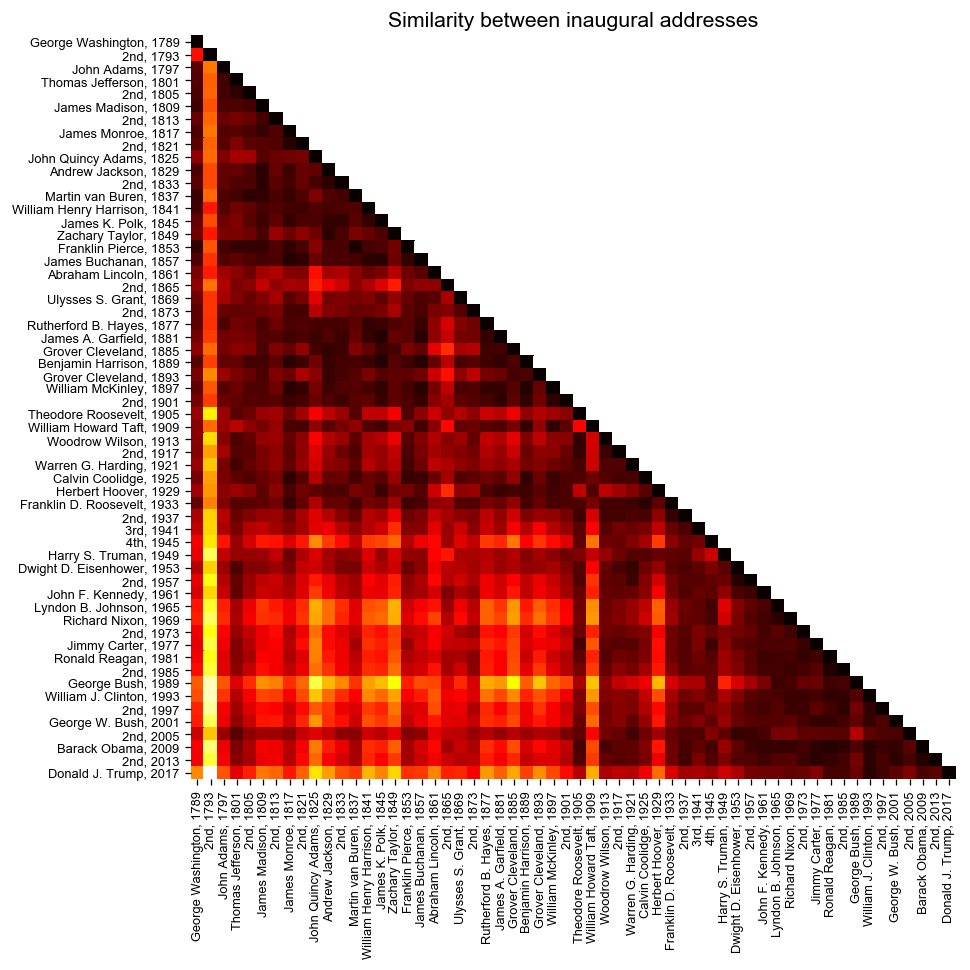

In [11]:
plt.figure(figsize=(8.5, 8.5))
ax = plotting.plot_pairwise_df(df_tril, plt)
# flip y-axis
ax.invert_yaxis()
ax.xaxis.label.set_visible(False)
ax.yaxis.label.set_visible(False)
plt.title('Similarity between inaugural addresses')
plt.tight_layout()
# plt.savefig('Similar-words-inaugurals_with_cosine.pdf')